# Import modules and init in gee


In [ ]:
import copy
import pickle
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

from scipy.stats.mstats import theilslopes
from hampel import hampel


plt.rcParams['axes.edgecolor'] = 'blue'
plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
import ee
import geemap.core as geemap

In [3]:
ee.Authenticate()

True

In [4]:
ee.Initialize(project='ee-airgit1')

In [ ]:
_df_all = pd.read_csv("../data/processed/chl_data.csv")
THRESHOLD = _df_all['CHL'].quantile(0.95)
df_all = _df_all[_df_all['CHL'] <= THRESHOLD]

# Implementation


## Function definition

### scale and mask

In [9]:
def scale_msi(image):
    opticalBands = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']).multiply(0.0001)
    return image.addBands(opticalBands, None, True)


def mask_S2_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    opticalBands = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'])
    
    mask_gt = opticalBands.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']) \
        .reduce(ee.Reducer.min()).gt(0)
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask.And(mask_gt))

### preproc images

In [ ]:
def preproc(ic: ee.ImageCollection, df: pd.DataFrame) -> list:
    """Mapping of id (datetime) to Image

    Args:
        ic (ee.ImageCollection): initial dataset
        df (pd.DataFrame): .csv
    
    Returns:
        dictionary of [ee.Image, dict of bands reduceRegion]
    """
    
    dict_stats = {key: value for key, value in zip(df.index.to_list(), df['datetime'].to_list())}
    for i in dict_stats:
        date_of_observation = ee.Date(df['datetime'][i])
        start_date = date_of_observation.advance(-1, 'day')
        end_date = date_of_observation.advance(1, 'day')
        
        img = ic.filterDate(start_date, end_date) \
            .filterBounds(ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i]))) \
                .map(scale_msi).map(mask_S2_clouds)
        found_stats = [None, None]
        if img.size().getInfo():
            img = img.toList(img.size())
            for j in range(img.length().getInfo()):
                v_mean = ee.Image(img.get(j)).reduceRegion(
                            reducer=ee.Reducer.median(),
                            geometry=ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])),
                            scale=20
                        ).getInfo()
                if v_mean['B3'] is not None:
                    found_stats[0] = ee.Image(img.get(j))
                    found_stats[1] = v_mean
                    break
        dict_stats[i] = found_stats
        
    for k, v in list(dict_stats.items()):
        if v[1] is None:
            del dict_stats[k]
    return dict_stats

### caclulation statistics

In [11]:
def mae_log(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += abs(np.log10(y_pred_pos[i]) - np.log10(ai))
    res /= len(in_situ)
    return 10 ** res


def bias_log(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += np.log10(y_pred_pos[i]) - np.log10(ai)
    res /= len(in_situ)
    return 10 ** res


def r2_cov(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    y_bar = y.mean()
    y_pred_bar = y_pred.mean()
    return np.pow(np.sum((y - y_bar) * (y_pred - y_pred_bar)) /
                  np.sqrt(np.sum(np.pow(y - y_bar, 2)) * np.sum(np.pow(y_pred - y_pred_bar, 2))), 2)
    
    
def bias(in_situ, pred):
    res = 0
    for i, ai in enumerate(in_situ):
        res += (pred[i] - ai)
    return res / len(in_situ)


def sen_slope(list_in_situ, list_calc):
    return theilslopes(list_in_situ, list_calc).slope


def std(in_situ, pred):
    return np.std(np.array(pred) - np.array(in_situ))


def calculate_statistics(list_in_situ, list_calc):
    arr = [r2_cov(list_in_situ, list_calc), bias_log(list_in_situ, list_calc),
            bias(list_in_situ, list_calc), mae_log(list_in_situ, list_calc), mean_absolute_error(list_in_situ, list_calc),
            np.sqrt(mean_squared_error(list_in_situ, list_calc)), std(list_in_situ, list_calc),
            sen_slope(list_calc, list_in_situ), mean_absolute_percentage_error(list_in_situ, list_calc) * 100]
    return list(map(lambda x: round(x, 3), arr))

### draw and estimated chl

In [ ]:
def draw_graphic(list1: list, list2: list, name_algo: str, save_folder: str = None):
    x = np.array(copy.deepcopy(list1)).reshape((-1, 1))
    y1 = np.array(copy.deepcopy(list2))
    model = LinearRegression().fit(x, y1)
    x_dots = np.linspace(x.min(), x.max(), 100).reshape((-1, 1))
    y_pred = model.predict(x_dots)
    
    plt.figure()
    plt.scatter(x, y1, c=[(0.7, 0.2, 0.9)], s=150,
                edgecolor='black', 
                linewidth=1.5,         
                alpha=0.9,           
                marker='o',           
                zorder=3)
    plt.plot(x_dots, y_pred, 'b', label='linear regression')
    plt.plot(x_dots, (st := theilslopes(list2, list1)).slope * x_dots + st.intercept, color='green', label='Theil–Sen estimator')
    plt.plot(x_dots, x_dots, '--', color='black', label='1:1 line')
    plt.xlabel(f"in_situ, Ug/L\nN = {len(list1) if 1 else 0}, Sen\'s slope = {st.slope:.3f}", fontsize=16, labelpad=10)
    plt.ylabel(f"{name_algo}, Ug/L", fontsize=16, labelpad=10)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if save_folder:
        os.makedirs(f"graphics/{save_folder}", exist_ok=True)
        filename = f"{name_algo}.png"
        save_path = os.path.join(f"graphics/{save_folder}", filename)
        
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()
        
    return round(std(list1, list2), 3)
    
    
def calculate_statistics_and_draw_graphic(df_in_situ: pd.DataFrame, **kwargs):
    dict_in_situ = {key: value for key, value in zip(df_in_situ.index.to_list(), df_in_situ['CHL'].to_list())}
    statistics = dict()
    for algo_name, algo_dict in kwargs.items():
        tmp_copy_calc = copy.deepcopy(algo_dict)
        for k, v in tmp_copy_calc.items():
            if v is None or v <= 0 or np.isnan(v) or abs(dict_in_situ[k] - tmp_copy_calc[k]) > 100:
                del algo_dict[k]
        tmp_copy_in_situ = copy.deepcopy(dict_in_situ)
        for k in list(tmp_copy_in_situ.keys()):
            if k not in algo_dict:
                del tmp_copy_in_situ[k]
        
        in_situ_values = list(tmp_copy_in_situ.values())
        calc_chl = list(algo_dict.values())
        if len(calc_chl) > 3:
            statistics[algo_name] = [*(_tmp := calculate_statistics(in_situ_values, calc_chl)), len(calc_chl), tmp_copy_in_situ, algo_dict]
            slope = draw_graphic(in_situ_values, calc_chl, algo_name, save_folder="regional")
        else:
            display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
        
    return statistics

### formulae in articles

#### Beck

In [13]:
def beck(values: dict):
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
    flh_violet = values['B3'] - (values['B4'] + ((665 - 560.5) / (665 - 490.5) * (values['B2'] - values['B4'])))
    _2bda = values['B5'] / values['B4']
    _3bda = ((1 / values['B4']) - (1 / values['B5'])) * values['B8A']
    
    ndci_chl = None if (_ndci := 0.388 * ndci - 18.844) < 0 else _ndci
    flh_violet_chl = None if (_flh_violet_chl := -0.033 * flh_violet + 53.064) < 0 else _flh_violet_chl
    _2bda_chl = None if (__2bda_chl := _2bda * 86.148 - 51.94) < 0 else __2bda_chl
    _3bda_chl = None if (__3bda_chl := 156.286 * _3bda + 35.982) < 0 else __3bda_chl
    return ndci_chl, flh_violet_chl, _2bda_chl, _3bda_chl

#### Molkov

In [ ]:
def molkov_linear(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None or (_ := a * x + b) < 0 else _
    
    
def molkov_poly(x, a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return None if x is None or (_ := a * np.pow(x, 2) + b * x + c) < 0 else _ 


def molkov_exp(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None else a * np.exp(b * x)
    
    
def molkov_power1(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None else a * np.pow(x, b)
    

def molkov_power2(x, a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return None if (x is None) or np.any(a * x + b < 0) else np.pow((a * x + b), c)
        

def molkov(values: dict) -> tuple:
    """For each values of bands calculate indecies, which looks like lists [lin, poly, exp, p1, p2]

    Returns:
        tuple of lists: dim = 8: ndci_list, _2bda_list, _3bda_list, ph_list, \n
        _2b_linear_result, _2b_poly_result, ndci_linear_result, ndci_poly_result
    """
    
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4'])
    _2bda = values['B5'] / values['B4']
    _3bda = ((1 / values['B4']) - (1 / values['B5'])) * values['B6']
    ph = values['B5'] - (values['B6'] + values['B4']) / 2
    
    ndci_list, _2bda_list, _3bda_list, ph_list = np.zeros(5, dtype=np.float64), np.zeros(5, dtype=np.float64), \
        np.zeros(5, dtype=np.float64), np.zeros(5, dtype=np.float64)
    
    ndci_list[0], _2bda_list[0], _3bda_list[0], ph_list[0] = molkov_linear(ndci, 90.101, 13.75), \
        molkov_linear(_2bda, 24.463, -8.356), molkov_linear(_3bda, 35.812, 19.24), molkov_linear(ph, 2340.123, 9.185)
    
    ndci_list[1], _2bda_list[1], _3bda_list[1], ph_list[1] = molkov_poly(ndci, 88.757, 52.715, 15.06), \
        molkov_poly(_2bda, -2.155, 33.034, -15.59), molkov_poly(_3bda, -10.227, 52.867, 16.91), molkov_poly(ph, -17567.0, 2814.313, 7.11)
    
    ndci_list[2], _2bda_list[2], _3bda_list[2], ph_list[2] = molkov_exp(ndci, 16.365, 2.754), \
        molkov_exp(_2bda, 12.546, 0.526), molkov_exp(_3bda, 25.114, 0.554), molkov_exp(ph, 17.808, 52.313)
    
    ndci_list[3], _2bda_list[3], _3bda_list[3], ph_list[3] = None, molkov_power1(_2bda, 17.346, 1.198), \
        None, molkov_power1(ph, 890.568, 0.708)
    
    ndci_list[4], _2bda_list[4], _3bda_list[4], ph_list[4] = molkov_power2(ndci, 6.251, 3.359, 2.217), \
        molkov_power2(_2bda, 96.806, -61.71, 0.764), molkov_power2(_3bda, 4373.068, 296.6, 0.479), molkov_power2(ph, 7834.173, 8.051, 0.789)
    
    _2b_linear_result = molkov_linear(_2bda, 64.536, -57.8)
    _2b_poly_result = molkov_poly(_2bda, -73.669, 252.808, -176.68)
    ndci_linear_result = molkov_linear(ndci, 167.293, 4.756)
    ndci_poly_result = molkov_poly(ndci, -300.26, 235.556, 1.586)
    return ndci_list, _2bda_list, _3bda_list, ph_list, \
        _2b_linear_result, _2b_poly_result, ndci_linear_result, ndci_poly_result


def convert_molkov_dict(index_dict: dict) -> tuple:
    """For each pair flatten lists to dict: id: [0, 1, 2, ...] -> dict(id: 0), dict(id: 1), ...

    Returns:
        tuple of dicts
    """
    _0, _1, _2, _3, _4 = dict(), dict(), dict(), dict(), dict()
    for k, v in index_dict.items():
        _0[k] = v[0]
        _1[k] = v[1]
        _2[k] = v[2]
        _3[k] = v[3]
        _4[k] = v[4]
    return _0, _1, _2, _3, _4

#### Li

In [15]:
def li_candidate13(x, a0, a1, a2, a3, a4):
    """
    Args:
        x: np.log10(values['B2'] / values['B3'])
    """
    return np.pow(10, a0 + a1 * x + a2 * np.pow(x, 2) + a3 * np.pow(x, 3) + a4 * np.pow(x, 4))


def li_candidate(values: dict):
    """
    ndci = None if values['B5'] < values['B4'] else (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
    _2bda1 = values['B6'] / values['B5']
    _2bda2 = values['B5'] / values['B4']
    _3bda = None if values['B5'] < values['B4'] else ((1 / values['B4']) - (1 / values['B5'])) * values['B6']
    """
    
    chl11 = None if (__chl11 := 136.3 * (values['B6'] / values['B4']) - 16.2) < 0 else __chl11
    
    chl12 = None if (__chl12 := 25.28 * (_chl12 := values['B5'] / values['B4'])**2 + 14.85 * _chl12 - 15.18) < 0 else __chl12
    
    chl13 = np.pow(10, 0.2389 - 1.9369 * (_chl13 := np.log10(values['B2'] / values['B3'])) +
                   1.7627 * _chl13**2 - 3.0777 * _chl13**3 - 0.1054 * _chl13**4)
    
    
    chl211 = None if \
        (__chl211 := 117.42 * ((1 / values['B4']) - (1 / values['B5'])) * values['B6'] + 23.09) < 0 else __chl211
        
    chl212 = None if \
        (__chl212 := 232.329 * ((1 / values['B4']) - (1 / values['B5'])) * values['B6'] + 23.174) < 0 else __chl212
        
    chl213 = None if \
        (__chl213 := 315.50 * (_chl213 := ((1 / values['B4'] - 1 / values['B5']) * values['B6']))**2 +
                      215.95 * _chl213 + 25.66) < 0 else __chl213
        
    chl22 = None if values['B6'] == values['B5'] or (__chl22 := \
        161.24 * (((1 / values['B4']) - (1 / values['B5'])) / ((1 / values['B6']) - (1 / values['B5']))) + 28.04) < 0 else __chl22
    return chl11, chl12, chl13, chl211, chl212, chl213, chl22

#### Makwinja

In [ ]:
def makwinja(values: dict):
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4'])
    return None if (_ndci := 431.98 * ndci**2 + 104 * ndci + 9.547) < 0 else _ndci

#### Boldanova

In [ ]:
def boldanova(values: dict):
    boldanova_b3 = None if (_boldanova_b3 := 3635.4 * (values['B3'])**2 - 185.7 * values['B3'] + 3.5) < 0 else _boldanova_b3
    return boldanova_b3

#### Karimi

In [18]:
def karimi(values: dict):
    _2bda = None if values['B4'] == 0 else \
        np.exp(3.4 * (__2bda := values['B5'] / values['B4'])**2 - 6.6 * __2bda + 4.9)
    ndci = np.exp(5.83 * (_ndci := (values['B5'] - values['B4']) / (values['B5'] + values['B4']))**2 + 0.075 * _ndci + 1.72)
    _3bda = np.exp(2.6 * (__3bda := ((1 / values['B4']) - (1 / values['B5'])) * values['B8A'])**2 - 0.2 * __3bda + 1.74)
    return _2bda, ndci, _3bda

#### O'Reilly

In [ ]:
def oc3_msi(x, a0, a1, a2, a3, a4):
    """
    Args:
        x: np.log10(max(values['B1'], values['B2']) / values['B3']))
    """
    return np.pow(10, a0 + a1 * x + a2 * np.pow(x, 2) + a3 * np.pow(x, 3) + a4 * np.pow(x, 4))


def oreilly(values: dict):
    oc3 = np.pow(10., 0.30963 - \
        2.40052 * (_oc3 := np.log10(max(values['B1'], values['B2']) / values['B3'])) + \
            1.28932 * _oc3**2 + 0.52802 * _oc3**3 - 1.33825 * _oc3**4)
    
    return oc3  # , oc4, oc5, oc6

### main

In [ ]:
def main(dict_stats: dict, df: pd.DataFrame, article: str):
    """Draw graphics and calculate satistics for each algo

    Args:
        df (pd.DataFrame): .csv

    Returns:
        {name_algo: []}
    """
    
    statistics = {}
    match article:
        case "beck":
            beck_ndci_chl = dict()
            beck_flh_violet_chl = dict()
            beck_2bda_chl = dict()
            beck_3bda_chl = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                beck_ndci_chl[k], beck_flh_violet_chl[k], beck_2bda_chl[k], beck_3bda_chl[k] = beck(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, beck_ndci=beck_ndci_chl, beck_flh_violet=beck_flh_violet_chl, \
                    beck_2bda=beck_2bda_chl, beck_3bda=beck_3bda_chl))
        
        case "molkov":
            molkov_ndci = dict()
            molkov_2bda = dict()
            molkov_3bda = dict()
            molkov_ph = dict()
            
            molkov_2b_linear_result = dict()
            molkov_2b_poly_result = dict()
            molkov_ndci_linear_result = dict()
            molkov_ndci_poly_result = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                molkov_ndci[k], molkov_2bda[k], molkov_3bda[k], molkov_ph[k], \
                    molkov_2b_linear_result[k], molkov_2b_poly_result[k], \
                        molkov_ndci_linear_result[k], molkov_ndci_poly_result[k] = molkov(v_mean)
            molkov_ndci_list_of_dict = convert_molkov_dict(molkov_ndci)
            molkov_2bda_list_of_dict = convert_molkov_dict(molkov_2bda)
            molkov_3bda_list_of_dict = convert_molkov_dict(molkov_3bda)
            molkov_ph_list_of_dict = convert_molkov_dict(molkov_ph)
            statistics.update(
                calculate_statistics_and_draw_graphic(df,
                                                      molkov_ndci_linear=molkov_ndci_list_of_dict[0], molkov_ndci_poly=molkov_ndci_list_of_dict[1],
                                                      molkov_ndci_exp=molkov_ndci_list_of_dict[2], molkov_ndci_power2=molkov_ndci_list_of_dict[4],
                                                      
                                                      molkov_2b_linear=molkov_2bda_list_of_dict[0], molkov_2b_poly=molkov_2bda_list_of_dict[1],
                                                      molkov_2b_exp=molkov_2bda_list_of_dict[2], molkov_2b_power1=molkov_2bda_list_of_dict[3],
                                                      molkov_2b_power2=molkov_2bda_list_of_dict[4],
                                                      
                                                      molkov_3b_linear=molkov_3bda_list_of_dict[0], molkov_3b_poly=molkov_3bda_list_of_dict[1],
                                                      molkov_3b_exp=molkov_3bda_list_of_dict[2], molkov_3b_power2=molkov_3bda_list_of_dict[4],
                                                      
                                                      molkov_ph_linear=molkov_ph_list_of_dict[0], molkov_ph_poly=molkov_ph_list_of_dict[1],
                                                      molkov_ph_exp=molkov_ph_list_of_dict[2], molkov_ph_power1=molkov_ph_list_of_dict[3],
                                                      molkov_ph_power2=molkov_ph_list_of_dict[4],
                                                      
                                                      molkov_2b_linear_result=molkov_2b_linear_result, molkov_2b_poly_result=molkov_2b_poly_result,
                                                      molkov_ndci_linear_result=molkov_ndci_linear_result, molkov_ndci_poly_result=molkov_ndci_poly_result))
        

        case "li":
            li_candidate11 = dict()
            li_candidate12 = dict()
            li_candidate13 = dict()
            li_candidate211 = dict()
            li_candidate212 = dict()
            li_candidate213 = dict()
            li_candidate22 = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                li_candidate11[k], li_candidate12[k], li_candidate13[k], li_candidate211[k], li_candidate212[k], \
                    li_candidate213[k], li_candidate22[k] = li_candidate(v_mean)
                print(k, li_candidate13[k], df.loc[k, 'CHL'])
            statistics.update(calculate_statistics_and_draw_graphic(df, li11=li_candidate11, li12=li_candidate12,
                                                                    li13=li_candidate13, li211=li_candidate211,
                                                                    li212=li_candidate212, li213=li_candidate213,
                                                                    li22=li_candidate22))
            
        case "makwinja":
            makwinja_ndci = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                makwinja_ndci[k] = makwinja(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, makwinja_ndci=makwinja_ndci))
            
        case "boldanova":
            boldanova_b3 = dict()
            
            for k, v in dict_stats.items():
                v_mean = v[1]
                boldanova_b3[k] = boldanova(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, boldanova_b3=boldanova_b3))
        
        case "karimi":
            karimi_2bda = dict()
            karimi_ndci = dict()
            karimi_3bda = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                karimi_2bda[k], karimi_ndci[k], karimi_3bda[k] = karimi(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, karimi_2bda=karimi_2bda, karimi_ndci=karimi_ndci,
                                                                    karimi_3bda=karimi_3bda))
            
        case "oreilly":
            oreilly_oc3 = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                oreilly_oc3[k] = oreilly(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, oc3_msi=oreilly_oc3))
            
    return statistics

In [ ]:
def convert_stat_dict_to_list_stat_and_values(arg_dict):
    """
    Args:
        arg_dict: {"name_algo1": [r2, bias, mae, n, {id: in situ}, {id: calculated}], "name_algo2": ...}
    
    Return: [{statustics (4 keys)}, {"name_algo" : [{id: in situ}, {id: calculated}]}]
    """
    
    statistics_dict = {}
    data_dict = {}
    for algo_name, algo_list in arg_dict.items():
        statistics_dict[algo_name] = algo_list[:-2]
        data_dict[algo_name] = [algo_list[-2], algo_list[-1]]
    return [statistics_dict, data_dict]

## EDA

In [24]:
ic_msi = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") 
    .filterDate('2018-05-25', '2023-09-29')
)

cci_lakes_path = "CCI_lakes/Chlorophyll-a - Global 1km - v2.1.0 - Lakes cci.csv"

In [26]:
with open("supplement/data_sent2.pickle", "rb") as file:
    dict_stats = pickle.load(file)

In [28]:
dict_stats = {k: v for k, v in dict_stats.items() if k in df_all.index}

# Results

### graphics

#### Beck (USA, 2016)

In [29]:
beck_data = main(dict_stats, df_all, "beck")

'Incorrect estimated values (count = 0): beck_ndci'

#### Molkov (Russia, 2019)

In [ ]:
molkov_data = main(dict_stats, df_all, "molkov")

/tmp/ipykernel_131732/3343679121.py:23: RuntimeWarning: invalid value encountered in power
  return None if x is None else a * np.pow(x, b)


#### Li (China, 2021)

In [31]:
li_candidate_data = main(dict_stats, df_all, "li")

45 2.1843892880305984 1.36
46 0.44776668396669755 0.2
47 0.5679629478282973 0.83
48 0.8860349876068655 0.55
49 0.9912159450676816 1.39
67 1.626588348495786 1.25
69 1.4825182893181714 0.82
80 1.2182414330428675 2.21
82 1.246397662252578 1.38
83 0.9599170329587549 1.8
85 1.4428875793283125 2.21
86 1.6727632337337797 2.22
87 1.559390601062593 2.48
90 1.0380329325499642 1.94
91 2.467047046220739 1.94
96 1.1813368985208208 1.39
98 1.3274995819190698 2.45
112 0.6398047037900125 0.72
113 0.6001928576581911 0.73
117 0.9087933622285738 0.76
120 0.7641367407703529 1.2
121 1.3747756090708094 1.6
128 1.831750828831712 1.67
129 1.6223833927790372 1.93
134 0.9909318701206898 1.4
138 0.9284839546822096 1.9
139 0.954653434422241 1.61
140 0.8023613114228302 2.36
141 3.1985159292052217 2.03
142 1.5755360956939224 0.9
143 1.0524427636160452 0.47
144 1.2077971742175602 0.89
145 1.9106595314867747 0.45
150 0.6106550505008213 0.89
151 0.9608950565906039 1.81
165 1.0620756815715187 2.35
168 1.116089353238868

#### Makwinja (Africa-Japan, 2022)

In [32]:
makwinja_data = main(dict_stats, df_all, "makwinja")

#### Boldanova (Russia, 2022)

In [33]:
boldanova_data = main(dict_stats, df_all, "boldanova")

#### Karimi (Iran, 2024)

In [34]:
karimi_data = main(dict_stats, df_all, "karimi")

#### O'Reilly (USA, 2019)

In [35]:
oreilly_data = main(dict_stats, df_all, "oreilly")

### statistics

In [36]:
columns = ['R^2', 'Bias_log', 'Bias', 'MAE_log', 'MAE',	'RMSE', 'std', 'SS', 'MAPE', 'N']

#### Beck

In [37]:
beck_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(beck_data)[0], orient='index', columns=columns)
beck_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
beck_flh_violet,0.080,44.064,51.685,44.064,51.685,51.689,0.638,-0.000,5304.882,90
beck_2bda,0.001,22.395,29.443,22.587,29.459,31.504,11.207,-1.142,2968.139,87
beck_3bda,0.003,25.687,33.022,25.687,33.022,35.507,13.050,-0.989,3346.679,84


#### Molkov

In [38]:
molkov_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(molkov_data)[0], orient='index', columns=columns)
molkov_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
molkov_ndci_linear,0.023,9.217,11.457,9.334,11.485,12.452,4.878,-0.909,1192.407,80
molkov_ndci_poly,0.002,11.457,12.796,11.457,12.796,13.193,3.210,-0.356,1342.167,90
molkov_ndci_exp,0.000,12.205,13.843,12.205,13.843,14.257,3.413,-0.188,1430.257,90
molkov_ndci_power2,0.002,9.786,11.914,10.679,11.957,12.636,4.210,-0.405,1233.219,89
molkov_2b_linear,0.000,12.067,13.665,12.067,13.665,14.071,3.355,-0.258,1407.140,88
molkov_2b_poly,0.000,10.947,12.619,10.947,12.619,13.229,3.970,-0.302,1298.171,88
molkov_2b_exp,0.000,17.098,19.286,17.098,19.286,19.369,1.798,-0.093,1994.415,90
molkov_2b_power1,0.000,13.056,14.831,13.056,14.831,15.201,3.333,-0.173,1529.589,90
molkov_2b_power2,0.002,10.578,12.547,10.578,12.547,13.237,4.219,-0.439,1280.224,85
molkov_3b_linear,0.008,14.575,16.630,14.575,16.630,17.067,3.840,-0.044,1703.281,89


#### Li

In [39]:
li_candidate_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(li_candidate_data)[0], orient='index', columns=columns)
li_candidate_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li11,0.005,59.049,72.873,59.049,72.873,76.024,21.660,-3.257,8415.759,40
li12,0.000,16.891,21.240,16.891,21.240,22.782,8.239,-0.692,2160.968,88
li13,0.043,1.025,-0.076,1.596,0.581,0.693,0.689,0.071,55.878,90
li211,0.015,15.164,20.363,15.164,20.363,22.352,9.217,-1.937,2095.911,81
li212,0.014,18.823,25.427,18.823,25.427,28.466,12.797,-2.392,2670.278,67
li213,0.018,16.737,25.466,17.902,25.531,29.457,14.805,-3.227,2641.485,77
li22,0.004,24.679,42.488,27.242,42.599,51.703,29.462,-1.162,4725.842,25


#### Makwinja 

In [40]:
makwinja_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(makwinja_data)[0], orient='index', columns=columns)
makwinja_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
makwinja_ndci,0.0,7.075,8.718,7.075,8.718,11.523,7.535,-0.563,918.275,89


#### Boldanova

In [41]:
boldanova_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(boldanova_data)[0], orient='index', columns=columns)
boldanova_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
boldanova_b3,0.001,2.023,5.67,2.568,6.071,16.958,15.982,-0.153,679.259,73


#### Karimi

In [42]:
karimi_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(karimi_data)[0], orient='index', columns=columns)
karimi_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
karimi_2bda,0.012,4.990,4.945,4.990,4.945,6.071,3.522,-0.009,581.816,90
karimi_ndci,0.014,4.994,5.078,4.994,5.078,7.033,4.866,-0.001,610.653,90
karimi_3bda,0.012,5.047,4.892,5.047,4.892,5.419,2.331,-0.002,525.680,90


#### O'Reilly

In [43]:
oreilly_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(oreilly_data)[0], orient='index', columns=columns)
oreilly_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_msi,0.025,0.949,-0.135,1.683,0.647,0.785,0.773,0.061,57.464,90


#### CCI

In [45]:
df_cci = pd.read_csv(cci_lakes_path)

In [46]:
cci(df_cci['Provided Value'], df_cci['Matched Value'])

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
CCI_lakes,0.224,0.666,-0.158,2.059,0.965,1.289,1.279,0.563,63.2,86


# Processing outliers

### Analysis 

In [43]:
def from_cci_lakes_to_id(df_cci: pd.DataFrame, df_init: pd.DataFrame) -> list:
    in_situ_dict, pred_dict = dict(), dict()
    for i in df_cci.index:
        for j in df_init.index:
            if df_init['LATITUDE'][j] == df_cci['Latitude'][i] and df_init['LONGITUDE'][j] == df_cci['Longitude'][i] and \
                df_init['CHL'][j] == df_cci['Provided Value'][i] and df_cci['Provided Date'][i] == df_init['datetime'][j]:
                    in_situ_dict[j], pred_dict[j] = df_init['CHL'][j], df_cci['Matched Value'][i]
                    break
    return in_situ_dict, pred_dict

In [47]:
cci_data = from_cci_lakes_to_id(df_cci, df_all)

In [48]:
def outliers(df_init: pd.DataFrame, threshold=3, n_sigma=1.1, window_size=3, **kwargs) -> list:
    """_summary_

    Args:
        df_init (pd.DataFrame): _description_
        window_size (int, optional): _description_. Defaults to 3.
        n_sigma (float, optional): _description_. Defaults to 3.0.

    Returns:
        list: df_pred, stat, indecies_dict
    """
    
    df_pred = copy.deepcopy(df_init)
    stat = dict()
    indecies_dict = dict()
    for algo_name, algo_dict in kwargs.items():
        in_situ = pd.Series(algo_dict[-2])
        predicted = pd.Series(algo_dict[-1])
        residual = np.abs(in_situ - predicted)
        
        indecies_true = np.array([])
        if len((inds_array := np.where(residual > threshold)[0])): 
            indecies_true = list((map(lambda t: in_situ.index[t], inds_array)))
            residual = np.delete(residual, inds_array)
        
        result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
        indecies = list(np.hstack((list(map(lambda t: in_situ.index[t], result.outlier_indices)), indecies_true)).astype(int))
        indecies_dict[algo_name] = indecies
        for i in indecies: 
            if i in in_situ: in_situ.pop(i), predicted.pop(i)
        
        indecies_series = pd.Series({k: True if k in indecies else np.nan for k in indecies})
        indecies_series.name = f'flag_hampel_{algo_name}'
        predicted_in_table = pd.Series(algo_dict[-1])
        predicted_in_table.name = algo_name
        df_pred = pd.concat([df_pred, predicted_in_table, indecies_series], axis=1)
               
        in_situ_values = copy.deepcopy(in_situ).to_list()
        calc_chl = predicted.to_list()
        if len(calc_chl) > 3:
            stat[algo_name] = [*(_tmp := calculate_statistics(in_situ_values, calc_chl)), len(calc_chl), in_situ, algo_dict]
            slope = draw_graphic(in_situ_values, calc_chl, algo_name, save_folder="regional")
            # stat[algo_name].insert(6, slope)
        else:
            display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
    for i in df_pred.index:
        if df_pred.loc[i, 'datetime':].isna().sum() == len(kwargs) * 2:
            df_pred.drop(labels=[i], inplace=True)        
    return df_pred, stat, indecies_dict

141, 91

In [70]:
li_candidate_data['li13'][-1].pop(141)

np.float64(3.1985159292052217)

In [59]:
li_candidate_data['li13'][-2]

{45: 1.36,
 46: 0.2,
 47: 0.83,
 48: 0.55,
 49: 1.39,
 50: 3.12,
 67: 1.25,
 69: 0.82,
 80: 2.21,
 82: 1.38,
 83: 1.8,
 85: 2.21,
 86: 2.22,
 87: 2.48,
 90: 1.94,
 91: 1.94,
 96: 1.39,
 97: 3.14,
 98: 2.45,
 112: 0.72,
 113: 0.73,
 117: 0.76,
 120: 1.2,
 121: 1.6,
 128: 1.67,
 129: 1.93,
 134: 1.4,
 138: 1.9,
 139: 1.61,
 140: 2.36,
 141: 2.03,
 142: 0.9,
 143: 0.47,
 144: 0.89,
 145: 0.45,
 150: 0.89,
 151: 1.81,
 165: 2.35,
 168: 2.15,
 169: 2.88,
 170: 3.13,
 173: 1.86,
 179: 0.83,
 180: 1.26,
 182: 2.21,
 183: 0.91,
 184: 2.32,
 185: 1.25,
 188: 0.65,
 189: 1.09,
 191: 1.28,
 192: 1.72,
 193: 2.87,
 194: 1.54,
 195: 2.03,
 201: 0.71,
 203: 2.7,
 204: 1.96,
 205: 1.73,
 206: 1.65,
 208: 1.41,
 210: 2.18,
 212: 1.29,
 214: 0.67,
 218: 0.41,
 219: 1.85,
 220: 1.7,
 221: 1.49,
 222: 1.08,
 225: 2.1,
 226: 1.04,
 228: 1.08,
 229: 0.73,
 230: 1.13,
 231: 0.51,
 232: 0.25,
 233: 0.16,
 234: 0.86,
 235: 0.62,
 236: 1.13,
 241: 0.91,
 242: 1.02,
 243: 1.02,
 244: 1.04,
 245: 1.04,
 246: 0.8

In [ ]:
clear_all_data_best = outliers(df_all, threshold=0.5,
                          li13_clear=li_candidate_data['li13'],
                          
                          oc3_msi_clear=oreilly_data['oc3_msi'])

### statistics

In [76]:
pd.DataFrame.from_dict({k: v[:-2] for k, v in clear_all_data_best[1].items()}, orient='index', columns=columns)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li13_clear,0.611,1.084,0.036,1.295,0.252,0.281,0.279,0.601,30.725,38
oc3_msi_clear,0.604,1.025,-0.006,1.321,0.270,0.306,0.306,0.725,30.886,37
CCI_lakes_clear,0.884,0.780,-0.180,1.382,0.275,0.311,0.253,1.018,26.105,28


# ML

In [ ]:
def do_cross_validation(estimator, X, y):
    scoring = {
        "R^2": make_scorer(r2_cov),
        "Bias_log": make_scorer(bias_log),
        "Bias": make_scorer(bias, greater_is_better=False),
        "MAE_log": make_scorer(mae_log),
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error",
        "std": make_scorer(std, greater_is_better=False),
        "Sen's slope": make_scorer(sen_slope),
        "MAPE": 'neg_mean_absolute_percentage_error'
    }
    
    cv_results = cross_validate(
        estimator, 
        X, 
        y, 
        scoring=scoring, 
        cv=5,
        return_estimator=True
    )
    
    for metric in scoring:
        values = cv_results[f"test_{metric}"]
        print(f"Cross-validated {metric}: ({' + '.join(f'{v:.2f}' for v in values)}) / 5 = {np.mean(values):.2f} +- {np.std(values):.2f}")
    
    for fold_idx, estimator in enumerate(cv_results['estimator']):
        if hasattr(estimator, 'best_params_'):
            print(f"Hyperparams (fold {fold_idx+1}): {estimator.best_params_}")
    
    return cv_results


def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


def nested_cv(df_rrs, sensor, name_bands, param_grid, scoring, model):
    name = 'SVR' if isinstance(model, SVR) else 'RF'
    X = df_rrs.loc[:, name_bands]
    target = df_rrs['CHL'].to_numpy().ravel()
    grid_model = GridSearchCV(make_pipeline(StandardScaler(), model), param_grid, cv=5,
                            scoring=scoring, return_train_score=True).fit(X, target)
    
    results = do_cross_validation(grid_model, X, target)
    
    return results, grid_model.best_estimator_   

C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

In [11]:
with open("supplement/data_sent2_all.pickle", "rb") as file:
    dict_stats = pickle.load(file)
    
df_all = _df_all

In [46]:
df_msi = df_all.loc[pd.Index(dict_stats.keys())]

## SVR

### rf

In [17]:
df_msi_rrs6 = create_rrs_df_rgr(df_msi, dict_stats)
nested_cv(df_msi_rrs6, 'MSI', df_msi_rrs6.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

Cross-validated R^2: (0.00 + 0.18 + 0.00 + 0.03 + 0.02) / 5 = 0.05 +- 0.07
Cross-validated Bias_log: (1.00 + 1.05 + 0.75 + 1.28 + 1.58) / 5 = 1.13 +- 0.28
Cross-validated Bias: (0.26 + 0.07 + 0.60 + -0.16 + -0.69) / 5 = 0.02 +- 0.43
Cross-validated MAE_log: (1.65 + 1.47 + 1.59 + 1.50 + 1.68) / 5 = 1.58 +- 0.08
Cross-validated MAE: (-0.67 + -0.51 + -0.80 + -0.41 + -0.79) / 5 = -0.63 +- 0.15
Cross-validated RMSE: (-0.86 + -0.57 + -0.97 + -0.52 + -1.14) / 5 = -0.81 +- 0.23
Cross-validated std: (-0.82 + -0.57 + -0.76 + -0.50 + -0.90) / 5 = -0.71 +- 0.15
Cross-validated Sen's slope: (-13.47 + -38.98 + 3.11 + -3.10 + -0.01) / 5 = -10.49 +- 15.30
Cross-validated MAPE: (-0.76 + -0.47 + -0.39 + -0.88 + -0.86) / 5 = -0.67 +- 0.20
Hyperparams (fold 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold 3): {'svr__C': np.float

({'fit_time': array([4.05084801, 4.03950286, 4.01983953, 4.04472232, 4.01873136]),
  'score_time': array([0.00269222, 0.0027864 , 0.002563  , 0.00265288, 0.00264144]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('svr', SVR())]),
                param_grid={'svr__C': array([  0.5       ,   0.92587471,   1.71448797,   3.1748021 ,
            5.87893797,  10.88632   ,  20.1587368 ,  37.32892927,
           69.12382329, 128.        ]),
                            'svr__epsilon': [0.1, 0.01],
                            'svr__gamma': array([0.0078125 , 0.01063117, 0.01446679, 0.01968627, 0.02678887,
          0.03645403, 0.04960628, 0.06750373, 0.09185841, 0.125     ])},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                            

In [ ]:
df_msi_rrs6_extra = create_rrs_df_rgr(
    df_msi, dict_stats, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})

In [46]:
df_all[df_all['CHL'] > 3].shape

(20, 13)

In [50]:
rf = RandomForestRegressor(random_state=42)
rf.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_msi_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()
nested_cv(df_msi_rrs6_extra, 'MSI', top_features, param_grid, 'neg_root_mean_squared_error', SVR())

Cross-validated R^2: (0.44 + 0.15 + 0.00 + 0.26 + 0.16) / 5 = 0.20 +- 0.15
Cross-validated Bias_log: (0.78 + 1.03 + 0.76 + 1.12 + 1.54) / 5 = 1.04 +- 0.28
Cross-validated Bias: (0.15 + 0.05 + 0.55 + -0.02 + -0.53) / 5 = 0.04 +- 0.35
Cross-validated MAE_log: (1.61 + 1.40 + 1.55 + 1.40 + 1.57) / 5 = 1.51 +- 0.09
Cross-validated MAE: (-0.37 + -0.42 + -0.73 + -0.35 + -0.57) / 5 = -0.49 +- 0.14
Cross-validated RMSE: (-0.49 + -0.51 + -0.89 + -0.44 + -0.61) / 5 = -0.59 +- 0.16
Cross-validated std: (-0.47 + -0.51 + -0.70 + -0.44 + -0.31) / 5 = -0.49 +- 0.13
Cross-validated Sen's slope: (0.72 + 0.86 + -0.42 + 1.15 + -0.26) / 5 = 0.41 +- 0.63
Cross-validated MAPE: (-0.45 + -0.40 + -0.38 + -0.43 + -0.61) / 5 = -0.45 +- 0.08
Hyperparams (fold 1): {'svr__C': np.float64(37.32892926643571), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.026788874464158525)}
Hyperparams (fold 2): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.125)}
Hyperparams (fold 3): {'s

({'fit_time': array([4.30839133, 4.38511658, 4.32347655, 4.32530093, 4.50060439]),
  'score_time': array([0.0028863 , 0.00264645, 0.00302672, 0.00275731, 0.00262523]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('svr', SVR())]),
                param_grid={'svr__C': array([  0.5       ,   0.92587471,   1.71448797,   3.1748021 ,
            5.87893797,  10.88632   ,  20.1587368 ,  37.32892927,
           69.12382329, 128.        ]),
                            'svr__epsilon': [0.1, 0.01],
                            'svr__gamma': array([0.0078125 , 0.01063117, 0.01446679, 0.01968627, 0.02678887,
          0.03645403, 0.04960628, 0.06750373, 0.09185841, 0.125     ])},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                            

* лучшая

In [51]:
nested_cv(df_msi_rrs6_extra, 'MSI', top_features, param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())    

Cross-validated R^2: (0.66 + 0.32 + 0.10 + 0.20 + 0.50) / 5 = 0.36 +- 0.20
Cross-validated Bias_log: (0.87 + 1.08 + 0.84 + 1.06 + 1.41) / 5 = 1.05 +- 0.20
Cross-validated Bias: (0.24 + -0.03 + 0.39 + 0.04 + -0.41) / 5 = 0.05 +- 0.27
Cross-validated MAE_log: (1.29 + 1.30 + 1.44 + 1.43 + 1.44) / 5 = 1.38 +- 0.07
Cross-validated MAE: (-0.33 + -0.32 + -0.61 + -0.37 + -0.44) / 5 = -0.42 +- 0.11
Cross-validated RMSE: (-0.45 + -0.46 + -0.76 + -0.47 + -0.48) / 5 = -0.52 +- 0.12
Cross-validated std: (-0.38 + -0.46 + -0.65 + -0.47 + -0.25) / 5 = -0.44 +- 0.13
Cross-validated Sen's slope: (1.22 + 1.13 + 0.91 + 0.45 + 0.62) / 5 = 0.87 +- 0.29
Cross-validated MAPE: (-0.23 + -0.38 + -0.34 + -0.45 + -0.45) / 5 = -0.37 +- 0.08
Hyperparams (fold 1): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 32}
Hyperparams (fold 2): {'randomforestregressor__max_depth': 5, 'randomforestregress

({'fit_time': array([ 9.16241908,  9.53297949,  9.73982978, 10.06351352,  9.87136912]),
  'score_time': array([0.00430679, 0.00457048, 0.00633216, 0.00481248, 0.00628161]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
                                           RandomForestRegressor())]),
                param_grid={'randomforestregressor__max_depth': [5, 10, 15],
                            'randomforestregressor__max_features': ['sqrt', 0.3],
                            'randomforestregressor__min_samples_split': [2, 5],
                            'randomforestregressor__n_estimators': [32, 64, 128]},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',


### bootstrap

In [62]:
def caledonia(model, n_resamples: int, df_rrs: pd.DataFrame) -> list:
    """_summary_

    Args:
        model: not trained
        df_rrs (pd.DataFrame): columns[-2] == CHL

    Returns:
        pd.DataFrame: RMSE + Sen's slope (mean, confidence interaval, Kruskal test) for each models
    """

    df_result = pd.DataFrame()
    all_features = list(
        itertools.chain.from_iterable(itertools.combinations(
            df_rrs.columns[:-1], r) for r in range(1, 7))
    )
    np.random.seed(42)
    bootstrap_samples_keys = np.random.choice(
        df_rrs.index, (n_resamples, df_rrs.shape[0]), replace=True)
    rmse_dict, sens_slope_dict = dict(), dict()
    keys, number_of_bands_dict = dict(), dict()
    rmse_full_dict, sens_slope_full_dict = dict(), dict()
    rmse_ci_dict, sens_slope_ci_dict = dict(), dict()

    for combo_idx, combo in enumerate(all_features):
        rmse_bs_current, sens_slope_bs_current = np.zeros(
            n_resamples, dtype=np.float64), np.zeros(n_resamples, dtype=np.float64)
        number_of_bands_dict[combo_idx] = len(combo)

        # ---
        df_full = df_rrs.loc[:, combo].join(df_rrs['CHL'])
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            df_full.iloc[:, :-1], df_full['CHL'],
            test_size=30, random_state=42
        )
        pipe_full = make_pipeline(StandardScaler(), model())
        pipe_full.fit(X_train_full, y_train_full)
        y_pred_full = pipe_full.predict(X_test_full)
        rmse_full_dict[combo_idx] = np.sqrt(
            mean_squared_error(y_test_full, y_pred_full))
        sens_slope_full_dict[combo_idx] = theilslopes(
            y_pred_full, y_test_full).slope
        # ---

        for i, indecies_current in enumerate(bootstrap_samples_keys):
            df_current = df_rrs.loc[indecies_current,
                                    combo].join(df_rrs['CHL'])
            X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
                df_current.iloc[:, :-1], df_current['CHL'], test_size=30, random_state=42)
            pipe = make_pipeline(StandardScaler(), model())
            pipe.fit(X_train_current, y_train_current)
            y_pred_current = pipe.predict(X_test_current)
            rmse_bs_current[i], sens_slope_bs_current[i] = np.sqrt(mean_squared_error(
                y_pred_current, y_test_current)), theilslopes(y_pred_current, y_test_current).slope
        
        rmse_ci_dict[combo_idx] = (_s1 := sorted(rmse_bs_current))[-2] - _s1[1]
        sens_slope_ci_dict[combo_idx] = (_s2 := sorted(sens_slope_bs_current))[-2] - _s2[1]
        rmse_dict[combo_idx], sens_slope_dict[combo_idx] = rmse_bs_current.mean(
        ), sens_slope_bs_current.mean()
        keys[combo_idx] = combo

    df_result['Number of used bands'] = number_of_bands_dict

    df_result['RMSE initial'] = rmse_full_dict
    df_result['RMSE mean'] = rmse_dict
    df_result['RMSE CI Length'] = rmse_ci_dict

    df_result['Sen\'s slope initial'] = sens_slope_full_dict
    df_result['Sen\'s slope mean'] = sens_slope_dict
    df_result['Sen\'s slope CI Length'] = sens_slope_ci_dict

    return df_result, keys

In [63]:
bs_result_msi = caledonia(SVR, 50, create_rrs_df_rgr(df_msi, dict_stats))

In [64]:
bs_result_msi[0].describe()

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,3.047619,0.495612,0.616138,0.360871,0.013599,0.028163,0.145827
std,1.183605,0.003754,0.001803,0.010615,0.005080,0.002938,0.012263
min,1.000000,0.488219,0.611877,0.319296,0.002567,0.019044,0.122667
25%,2.000000,0.493946,0.614820,0.353976,0.010412,0.025937,0.137573
50%,3.000000,0.495017,0.615903,0.360378,0.013911,0.028533,0.143039
75%,4.000000,0.497038,0.616769,0.368964,0.017189,0.029740,0.155450
max,6.000000,0.519654,0.620876,0.376229,0.026262,0.035520,0.174934


In [ ]:
bs_result_msi[0].sort_values('RMSE mean').head(10)

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
2,1,0.519654,0.611877,0.355298,0.003294,0.035520,0.157446
11,2,0.498635,0.613154,0.353909,0.020937,0.032218,0.148719
31,3,0.497308,0.613791,0.362441,0.021791,0.031068,0.153252
32,3,0.499115,0.613816,0.363248,0.018791,0.032179,0.171493
33,3,0.497260,0.613930,0.364005,0.015931,0.032212,0.174934
15,2,0.496989,0.614144,0.367694,0.022783,0.033414,0.172847
16,2,0.499190,0.614156,0.369387,0.018126,0.033214,0.150843
7,2,0.493889,0.614216,0.339077,0.018280,0.030912,0.143726
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012
41,4,0.494242,0.614325,0.353015,0.017476,0.029000,0.136007


In [66]:
bs_result_msi[0].sort_values('RMSE CI Length').head(10)

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
0,1,0.488219,0.620876,0.319296,0.006942,0.019044,0.124930
6,2,0.491444,0.616304,0.339064,0.014723,0.023238,0.129970
7,2,0.493889,0.614216,0.339077,0.018280,0.030912,0.143726
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012
10,2,0.491845,0.619488,0.344855,0.003419,0.023367,0.142474
9,2,0.492804,0.618540,0.345565,0.011127,0.024543,0.143303
8,2,0.490842,0.618034,0.348331,0.014497,0.024940,0.129108
22,3,0.492351,0.615757,0.352523,0.016901,0.025342,0.128376
27,3,0.493924,0.615393,0.353006,0.015557,0.029806,0.143414
41,4,0.494242,0.614325,0.353015,0.017476,0.029000,0.136007


In [67]:
bs_result_msi[0].sort_values('RMSE CI Length').loc[[11, 31, 21], :]

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
11,2,0.498635,0.613154,0.353909,0.020937,0.032218,0.148719
31,3,0.497308,0.613791,0.362441,0.021791,0.031068,0.153252
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012


In [68]:
___ = create_rrs_df_rgr(df_msi, dict_stats)

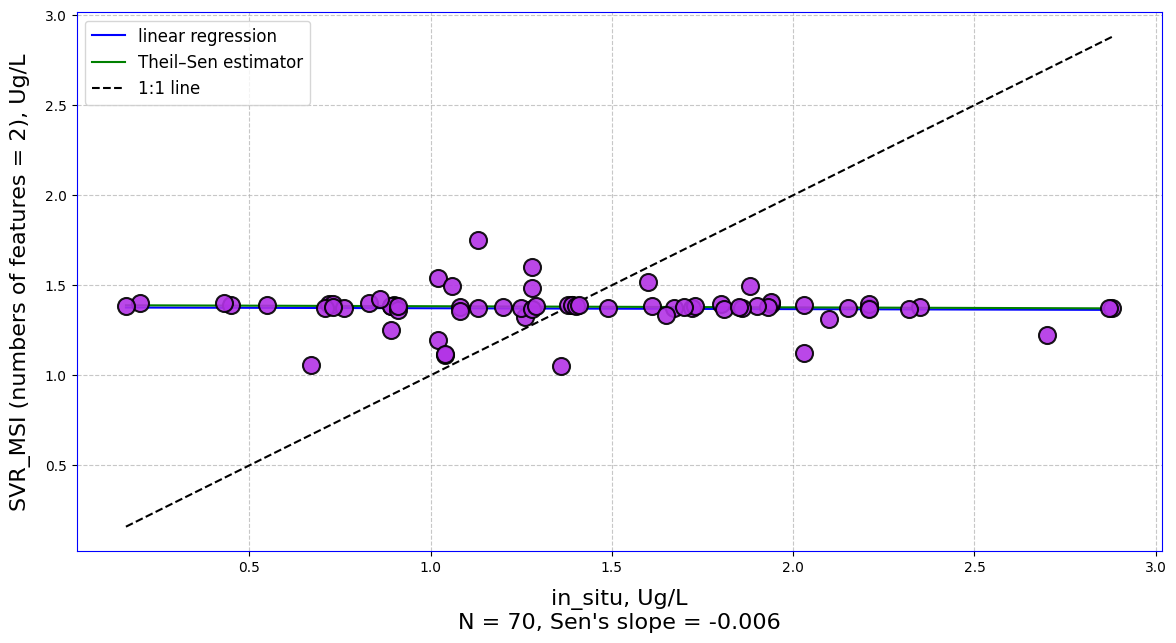

-0.6016979157244212
Cross-validated R^2: (0.01 + 0.15 + 0.01 + 0.05 + 0.04) / 5 = 0.05
Cross-validated Bias_log: (1.19 + 1.07 + 0.77 + 1.19 + 1.30) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.03 + 0.53 + -0.05 + -0.39) / 5 = 0.02
Cross-validated MAE_log: (1.63 + 1.47 + 1.56 + 1.48 + 1.52) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.73 + -0.40 + -0.54) / 5 = -0.54
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.81) / 5 = -0.67
Cross-validated std: (-0.63 + -0.55 + -0.70 + -0.50 + -0.71) / 5 = -0.62
Cross-validated Sen's slope: (-5.92 + -32.67 + 2.01 + -1.48 + 0.22) / 5 = -7.57
Cross-validated MAPE: (-0.83 + -0.47 + -0.38 + -0.80 + -0.59) / 5 = -0.62

Hyperparams (fold number = 1): {'svr__C': np.float64(1.7144879657061456), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.026788874464158525)}
Hyperparams (fold number = 3): {'svr__C': np.float6

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B2', 'B3'))",0.049469,1.106486,0.019148,1.529723,0.538405,0.673343,0.617566,-7.568011,0.615993,70


In [69]:
nested_cv(___, 'MSI', bs_result_msi[1][11], param_grid, 'neg_root_mean_squared_error', SVR())

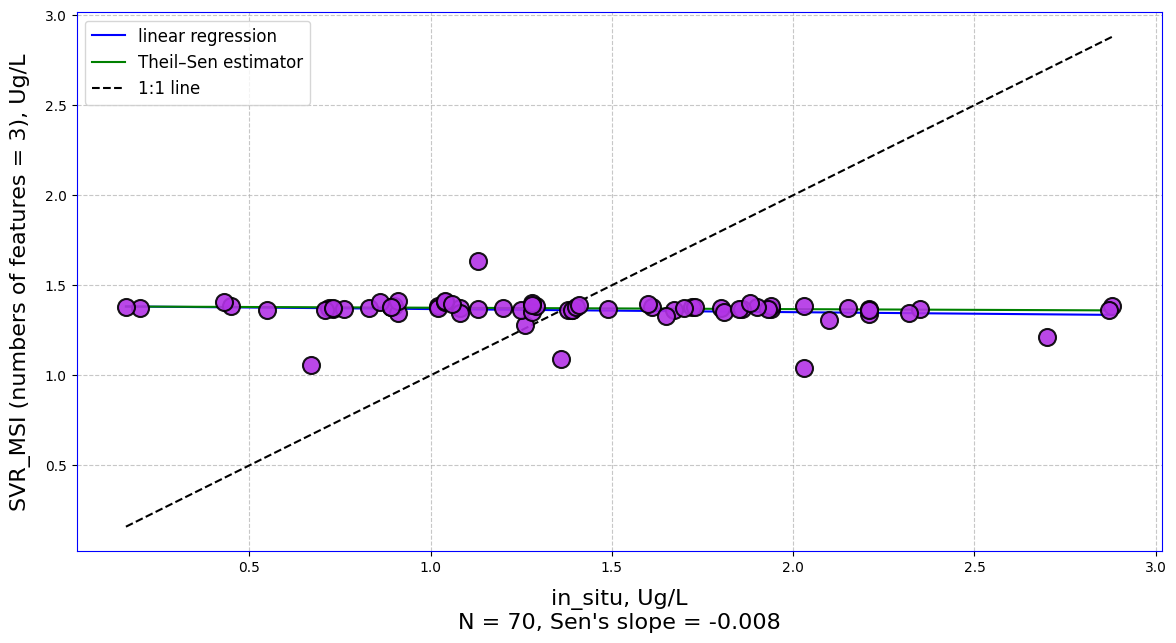

-0.6052000421541953
Cross-validated R^2: (0.00 + 0.12 + 0.01 + 0.05 + 0.05) / 5 = 0.04
Cross-validated Bias_log: (1.19 + 1.06 + 0.77 + 1.19 + 1.34) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.05 + 0.53 + -0.05 + -0.37) / 5 = 0.03
Cross-validated MAE_log: (1.63 + 1.47 + 1.55 + 1.48 + 1.52) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.73 + -0.40 + -0.50) / 5 = -0.53
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.58) / 5 = -0.63
Cross-validated std: (-0.63 + -0.55 + -0.70 + -0.50 + -0.45) / 5 = -0.57
Cross-validated Sen's slope: (-5.19 + -24.23 + 1.22 + -3.62 + 0.21) / 5 = -6.32
Cross-validated MAPE: (-0.83 + -0.47 + -0.38 + -0.80 + -0.57) / 5 = -0.61

Hyperparams (fold number = 1): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 3): {'svr__C': np.float6

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B1', 'B2', 'B3'))",0.04407,1.111791,0.0273,1.530731,0.529661,0.628093,0.565048,-6.32208,0.610051,70


In [70]:
nested_cv(___, 'MSI', bs_result_msi[1][21], param_grid, 'neg_root_mean_squared_error', SVR())

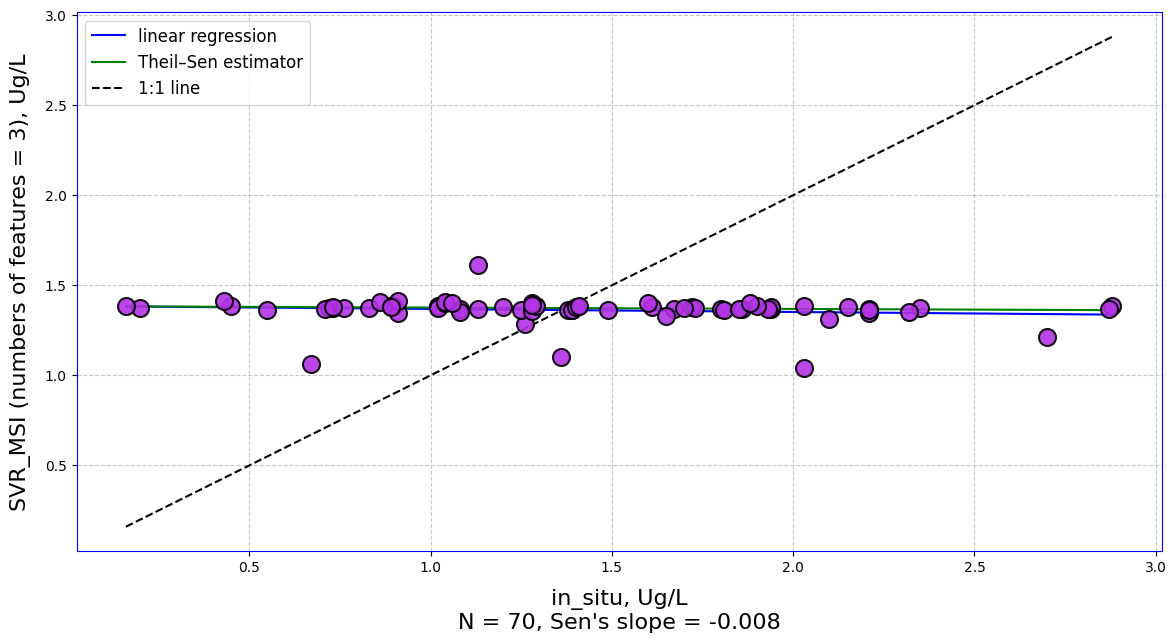

-0.6045879973159146
Cross-validated R^2: (0.00 + 0.19 + 0.01 + 0.05 + 0.06) / 5 = 0.06
Cross-validated Bias_log: (1.19 + 1.06 + 0.78 + 1.19 + 1.35) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.05 + 0.52 + -0.05 + -0.37) / 5 = 0.02
Cross-validated MAE_log: (1.63 + 1.47 + 1.56 + 1.48 + 1.48) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.74 + -0.40 + -0.48) / 5 = -0.53
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.59) / 5 = -0.63
Cross-validated std: (-0.63 + -0.55 + -0.71 + -0.50 + -0.46) / 5 = -0.57
Cross-validated Sen's slope: (-4.10 + -47.30 + -0.65 + -4.44 + 0.20) / 5 = -11.26
Cross-validated MAPE: (-0.83 + -0.47 + -0.39 + -0.80 + -0.54) / 5 = -0.61

Hyperparams (fold number = 1): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 3): {'svr__C': np.floa

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B2', 'B3', 'B4'))",0.061779,1.114673,0.023884,1.525296,0.527293,0.629737,0.567716,-11.257918,0.606791,70


In [71]:
nested_cv(___, 'MSI', bs_result_msi[1][31], param_grid, 'neg_root_mean_squared_error', SVR())

## RF

In [52]:
_ = create_rrs_df_rgr(df_msi, dict_stats)
nested_cv(_, 'MSI', _.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

Cross-validated R^2: (0.04 + 0.02 + 0.22 + 0.15 + 0.11) / 5 = 0.11 +- 0.07
Cross-validated Bias_log: (1.27 + 0.99 + 0.78 + 1.28 + 1.42) / 5 = 1.15 +- 0.23
Cross-validated Bias: (-0.14 + 0.12 + 0.50 + -0.16 + -0.40) / 5 = -0.02 +- 0.31
Cross-validated MAE_log: (1.65 + 1.46 + 1.64 + 1.50 + 1.48) / 5 = 1.54 +- 0.08
Cross-validated MAE: (-0.56 + -0.48 + -0.78 + -0.41 + -0.46) / 5 = -0.54 +- 0.13
Cross-validated RMSE: (-0.65 + -0.58 + -0.97 + -0.49 + -0.51) / 5 = -0.64 +- 0.17
Cross-validated std: (-0.64 + -0.57 + -0.83 + -0.47 + -0.32) / 5 = -0.57 +- 0.17
Cross-validated Sen's slope: (0.05 + 0.12 + -1.10 + 1.03 + 0.69) / 5 = 0.16 +- 0.73
Cross-validated MAPE: (-0.86 + -0.46 + -0.42 + -0.78 + -0.51) / 5 = -0.61 +- 0.18
Hyperparams (fold 1): {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 64}
Hyperparams (fold 2): {'randomforestregressor__max_depth': 5, 'randomforestregr

({'fit_time': array([9.63341165, 9.7135551 , 9.3540628 , 9.65369272, 9.83123255]),
  'score_time': array([0.00605059, 0.00881243, 0.00443554, 0.0046761 , 0.00484729]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
                                           RandomForestRegressor())]),
                param_grid={'randomforestregressor__max_depth': [5, 10, 15],
                            'randomforestregressor__max_features': ['sqrt', 0.3],
                            'randomforestregressor__min_samples_split': [2, 5],
                            'randomforestregressor__n_estimators': [32, 64, 128]},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
     

In [53]:
__ = create_rrs_df_rgr(
    df_msi, dict_stats,
    emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']}
)
nested_cv(__, 'MSI', __.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

Cross-validated R^2: (0.37 + 0.02 + 0.03 + 0.48 + 0.23) / 5 = 0.23 +- 0.18
Cross-validated Bias_log: (1.14 + 1.23 + 0.80 + 1.20 + 1.48) / 5 = 1.17 +- 0.22
Cross-validated Bias: (-0.03 + -0.20 + 0.47 + -0.09 + -0.47) / 5 = -0.07 +- 0.31
Cross-validated MAE_log: (1.44 + 1.37 + 1.54 + 1.40 + 1.52) / 5 = 1.45 +- 0.07
Cross-validated MAE: (-0.40 + -0.41 + -0.71 + -0.33 + -0.52) / 5 = -0.47 +- 0.13
Cross-validated RMSE: (-0.49 + -0.62 + -0.90 + -0.39 + -0.56) / 5 = -0.59 +- 0.17
Cross-validated std: (-0.49 + -0.58 + -0.76 + -0.37 + -0.30) / 5 = -0.50 +- 0.16
Cross-validated Sen's slope: (0.72 + 0.39 + -1.28 + 1.35 + 0.18) / 5 = 0.27 +- 0.87
Cross-validated MAPE: (-0.54 + -0.52 + -0.38 + -0.51 + -0.54) / 5 = -0.50 +- 0.06
Hyperparams (fold 1): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 32}
Hyperparams (fold 2): {'randomforestregressor__max_depth': 10, 'randomforestre

({'fit_time': array([10.70485854, 10.29529977, 10.51302075, 10.49333429, 10.44762206]),
  'score_time': array([0.00481796, 0.00467634, 0.00478029, 0.00603533, 0.00466704]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
                                           RandomForestRegressor())]),
                param_grid={'randomforestregressor__max_depth': [5, 10, 15],
                            'randomforestregressor__max_features': ['sqrt', 0.3],
                            'randomforestregressor__min_samples_split': [2, 5],
                            'randomforestregressor__n_estimators': [32, 64, 128]},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
